In [ ]:
import numpy as np
import torch
import cv2
from cellpose.dynamics import masks_to_flows

# ============================================================================
# CONFIGURE PATHS
# ============================================================================
Cellpose_path = '/dataset_processing/CellPose-train/'
anns_file     = Cellpose_path + 'anns.npy'   # Your labeled masks
imgs_file     = Cellpose_path + 'imgs.npy'   # (Optional) if you want the raw images
out_file      = Cellpose_path + 'flows.npy'  # We'll save (dy, dx, cell_prob)

# ============================================================================
# LOAD ARRAYS
# ============================================================================
anns = np.load(anns_file) 
print("anns.shape:", anns.shape)

imgs = np.load(imgs_file)
print("imgs.shape:", imgs.shape)

# ============================================================================
# A HELPER FUNCTION TO EXTRACT A SINGLE LABEL IMAGE
# Adjust as needed depending on the shape of your `anns`
# ============================================================================
def get_mask(anns, idx):
    """
    If anns has shape (N, 2, H, W) and channel=0 is the labeled mask,
    we return that. If your shape is different, adjust accordingly.
    """
    return anns[idx, 0]

# Decide on CPU or GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

N = anns.shape[0]
flows_all = []  # will accumulate [N, 3, H, W] eventually

# ============================================================================
# LOOP OVER EACH EXAMPLE AND CREATE (dx, dy, cell_prob)
# ============================================================================
for i in range(N):
    # Get the labeled mask for index i
    label_img = get_mask(anns, i).astype(int)  # shape (H, W)
    
    # -- 1) Compute flow field (dy, dx) using Cellpose
    # returns array shape (2, H, W)
    flows_2d = masks_to_flows(label_img, device=device)
    flow_dx = flows_2d[1]
    flow_dy = flows_2d[0]
    
    # -- 2) Compute a "cell probability" channel using a distance transform 
    #    (distance from boundary). We do this on the binary mask of all cells.
    binary_mask = (label_img > 0).astype(np.uint8)
    # Distance transform needs a binary image, 0 for background, 1 for foreground
    dist_map = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=3)
    
    # Normalize to [0,1] to get "cell probability"-like
    max_dist = dist_map.max()
    if max_dist > 0:
        dist_map /= max_dist
    
    # We call dist_map the "cell_prob" channel
    cell_prob = dist_map.astype(np.float32)

    # Stack them into [3, H, W]
    # channel 0 = dx, channel 1 = dy, channel 2 = cell_prob
    flows_3ch = np.stack([flow_dx, flow_dy, cell_prob], axis=0)  # shape (3, H, W)
    
    flows_all.append(flows_3ch)

# ============================================================================
# CONVERT TO NUMPY ARRAY & SAVE
# ============================================================================
flows_all = np.array(flows_all, dtype=np.float32)  # shape (N, 3, H, W)
print("flows_all.shape:", flows_all.shape)
np.save(out_file, flows_all)
print("Saved flows (dx, dy, cellprob) to:", out_file)


anns.shape: (540, 2, 512, 512)
imgs.shape: (540, 512, 512)
flows_all.shape: (540, 3, 512, 512)
Random index: 311


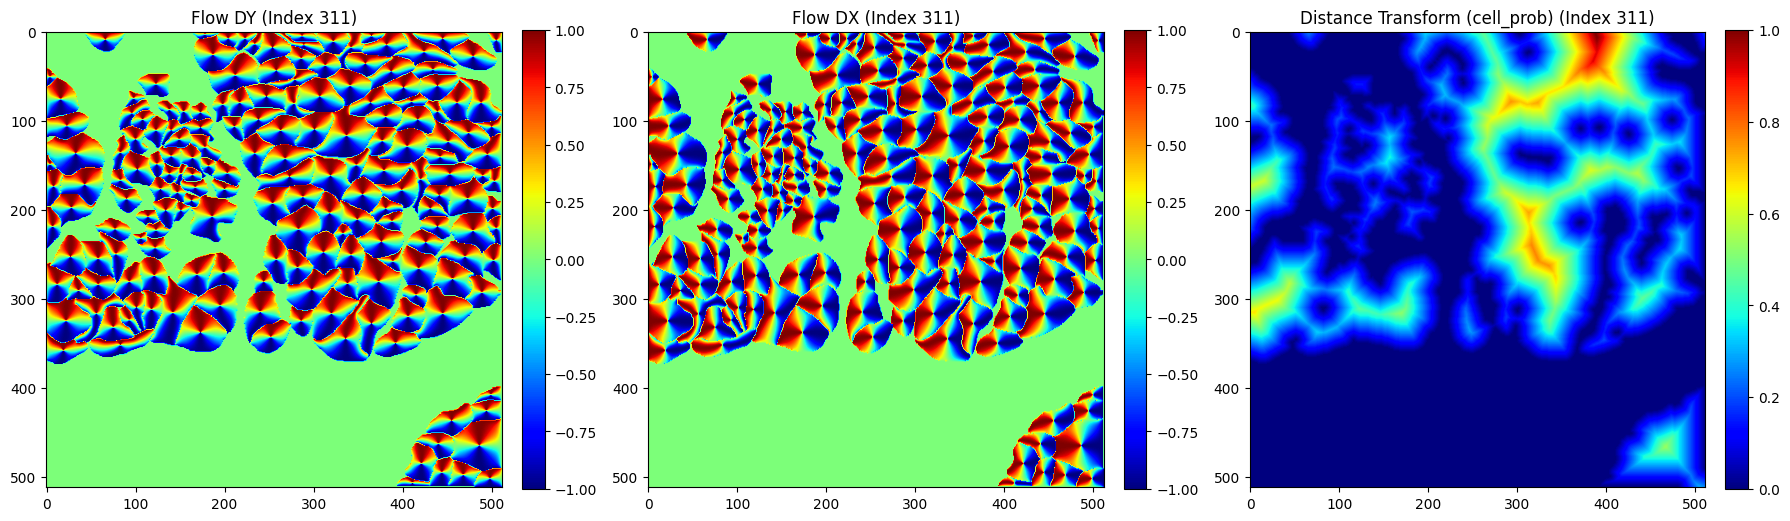

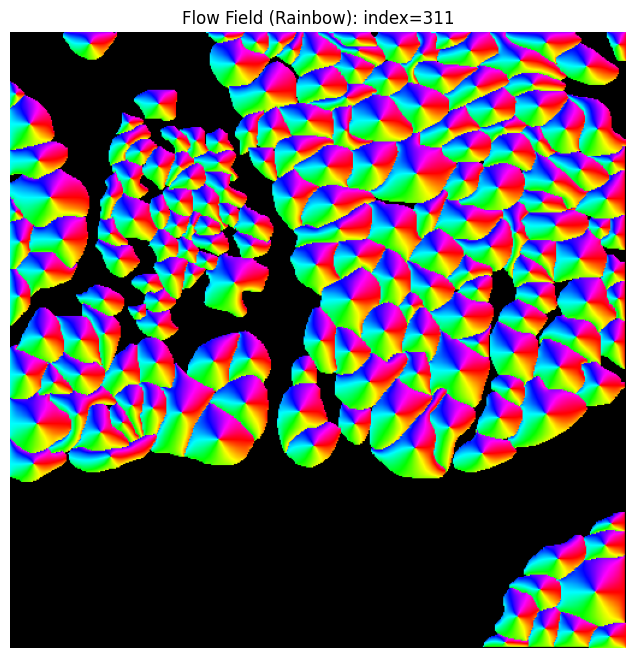

In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cellpose.dynamics import masks_to_flows

# Path to your labeled mask array and flows
Cellpose_path = '/Users/saahilsanganeriya/Documents/Saahil/PBL/SAMCellv2.0/dataset_processing/CellPose-train/'
anns_file = Cellpose_path + 'anns.npy'  # or wherever your .npy is
imgs_file = Cellpose_path + 'imgs.npy'
flows_file = Cellpose_path + 'flows.npy'  # Path to the precomputed flows.npy

# Load the arrays
anns = np.load(anns_file)
print("anns.shape:", anns.shape)

imgs = np.load(imgs_file)
print("imgs.shape:", imgs.shape)

flows_all = np.load(flows_file)
print("flows_all.shape:", flows_all.shape)  # Expected shape: (N, 3, H, W)

# Number of images
N = anns.shape[0]

# Pick a random index
idx = random.randint(0, N-1)
print("Random index:", idx)

# Extract the flows for the selected index
flow_dx = flows_all[idx, 0]      # dx channel
flow_dy = flows_all[idx, 1]      # dy channel
cell_prob = flows_all[idx, 2]    # cell_prob channel

# --- Visualize the Flows and Distance Transform ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Flow DY
im1 = axs[0].imshow(flow_dy, cmap='jet')
axs[0].set_title(f"Flow DY (Index {idx})")
plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

# Flow DX
im2 = axs[1].imshow(flow_dx, cmap='jet')
axs[1].set_title(f"Flow DX (Index {idx})")
plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

# Distance Transform (cell_prob)
im3 = axs[2].imshow(cell_prob, cmap='jet')
axs[2].set_title(f"Distance Transform (cell_prob) (Index {idx})")
plt.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Build the HSV image for Flow Field ---
# 1) Angle in [-pi, pi]
angle = np.arctan2(flow_dy, flow_dx)
# Normalize to [0,1] for hue
angle_normalized = (angle + np.pi) / (2 * np.pi)

# 2) Magnitude
mag = np.sqrt(flow_dx**2 + flow_dy**2)
# You can clamp or scale the magnitude (optional)
mag_clamped = np.clip(mag, 0, 1)  # For demonstration

# 3) Create HSV image [H, S, V]
hsv = np.zeros((flow_dy.shape[0], flow_dy.shape[1], 3), dtype=np.float32)
hsv[..., 0] = angle_normalized      # Hue
hsv[..., 1] = 1.0                   # Saturation = 1
hsv[..., 2] = mag_clamped           # Value = Magnitude in [0,1]

# 4) Convert to RGB
rgb = mcolors.hsv_to_rgb(hsv)

# Plot the HSV Flow Field
plt.figure(figsize=(8, 8))
plt.title(f'Flow Field (Rainbow): index={idx}')
plt.imshow(rgb)
plt.axis('off')
plt.show()
